In [14]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import shap
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt

import joblib
import os
import json

figs_folder='../artifacts'
os.makedirs(figs_folder, exist_ok=True)

# Regression on Response Time

In [4]:
# Load data

file_path = os.path.join("..","data","processed_data.csv")

df = pd.read_csv(file_path)  

print(len(df))
df.head()

364


,Response Time,Availability,Throughput,Successability,Reliability,Compliance,Best Practices,Latency,Documentation,WsRF,Class,Service Name_0,Service Name_1,Service Name_2,Service Name_3
0,45.00,83.0,5.6,50,97.4,89,91.0,43.00,58,100.0,1,0,0,0,0
1,71.75,100.0,14.6,88,85.5,78,80.0,64.42,86,93.0,1,0,0,0,0
2,117.00,100.0,23.4,83,88.0,100,87.0,111.00,59,90.0,1,0,0,0,0
3,70.00,100.0,5.4,83,79.3,100,75.0,63.00,91,90.0,1,0,0,0,0
4,105.20,100.0,18.2,80,92.2,78,84.0,104.60,91,90.0,1,0,0,0,0


In [5]:
X_baseline=df.drop(columns=['Response Time', 'Latency', 'Service Name_0', 'Service Name_1', 'Service Name_2', 'Service Name_3', 'Compliance', 'Class', 'WsRF'])
Y_baseline=df['Response Time']

# Baseline

In [6]:
baseline_reg=LinearRegression()

X_rest, X_test, y_rest, y_test = train_test_split(
    X_baseline, Y_baseline, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_rest, y_rest, test_size=0.53, random_state=42
)


k_folds = KFold(n_splits=5)

scores = cross_val_score(baseline_reg, X_rest, y_rest, cv=k_folds, scoring='r2')
print(scores)
print(f"{baseline_reg}: CV R² mean={scores.mean():.4f}")

[ 0.02835219 -0.33099366  0.17048235  0.06691947  0.05912458]
LinearRegression(): CV R² mean=-0.0012


- feature importance 

ExactExplainer explainer: 310it [00:24, 12.80it/s]                          


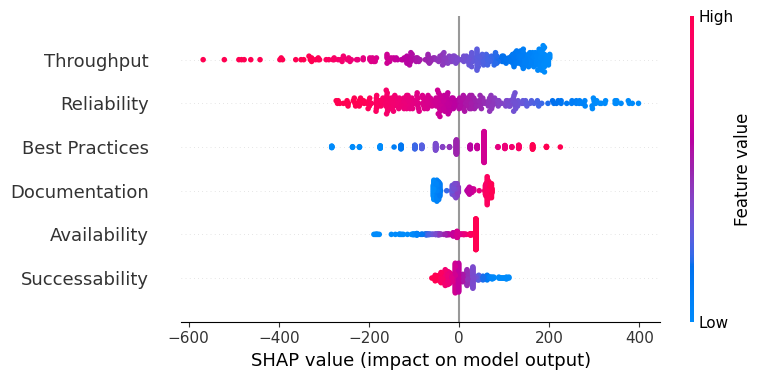

<Figure size 640x480 with 0 Axes>

In [7]:
baseline_reg.fit(X_rest,y_rest)
explainer = shap.Explainer(baseline_reg.predict, X_rest)  
shap_values = explainer(X_rest)

shap.summary_plot(shap_values, X_rest)

plt.savefig( os.path.join(figs_folder,'regression_shap.png') )

[0.00593735 0.10028515 0.00641024 0.09174616 0.03741368 0.00758731]


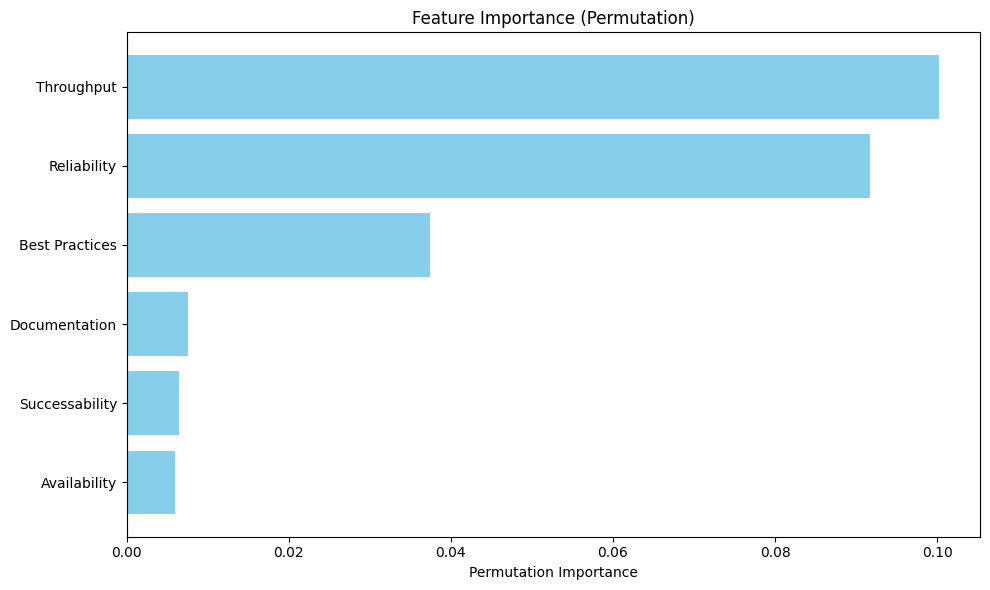

<Figure size 640x480 with 0 Axes>

In [8]:
#baseline_reg.fit(X_rest, y_rest)
result = permutation_importance(baseline_reg, X_rest, y_rest, n_repeats=10, random_state=42)
print(result.importances_mean)


# Feature names and importance values
importances = result.importances_mean
features = X_rest.columns

# Create DataFrame for sorting
df = pd.DataFrame({'Feature': features, 'Importance': importances})
df_sorted = df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(figs_folder, "regression_permutation_importance.png"))

With feature importance (SHAP) Service Name, compliance, and class (and so WsRF) variables must be removed as could likely cause leakage and bias

# RandomizedSearch CV

In [9]:

param_distributions = {
    'ridge': {
        'model__alpha': np.logspace(-3, 1, 10)
    },
    'lasso': {
        'model__alpha': np.logspace(-3, 1, 10)
    },
    'ransac': {
        'min_samples': [0.5, 0.75, 0.9],
        'residual_threshold': [1.0, 2.0, 5.0]
    },
    'rf_reg': {
        'n_estimators': np.arange(50, 300, 50),
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'svr': {
        'model__C': np.logspace(-2, 2, 5),
        'model__epsilon': [0.01, 0.1, 0.5, 1],
        'model__kernel': ['linear', 'rbf']
    },
    'poly_reg': {
        'poly_features__degree': [2, 3, 4]
    }
}

Tried with both MinMax and Standard scalers but no imporvements seem significant

In [ ]:
reg_scores = {}
best_models = {}
cv_results = {}

scalers = [StandardScaler(), MinMaxScaler()]

for scaler in scalers:
    print(scaler)
    regressors = {
        'ridge': Pipeline([
            ('scaler', scaler),
            ('model', Ridge())
        ]),
        'lasso': Pipeline([
            ('scaler', scaler),
            ('model', Lasso())
        ]),
        'ransac': RANSACRegressor(random_state=42),
        'tree_reg': DecisionTreeRegressor(),
        'rf_reg': RandomForestRegressor(random_state=42),
        'svr': Pipeline([
            ('scaler', scaler),
            ('model', SVR())
        ]),
        'poly_reg': Pipeline([
            ('scaler', scaler),
            ('poly_features', PolynomialFeatures(include_bias=False)),
            ('model', LinearRegression())
        ])
    }


    k_folds = KFold(n_splits=5)

    # Loop through regressors
    for name, reg in regressors.items():
        if name in param_distributions:
            # Apply RandomizedSearchCV for models with hyperparameters
            search = RandomizedSearchCV(
                reg,
                param_distributions=param_distributions[name],
                n_iter=10,
                scoring='r2',
                cv=k_folds,
                n_jobs=-1,
                random_state=42
            )
            search.fit(X_rest, y_rest)
            best_models[name] = search.best_estimator_
            reg_scores[name] = search.best_score_
            print(f"{name}: Best CV R²={search.best_score_:.4f}, Params={search.best_params_}")
            
            cv_results[name] = {
                "best_score": search.best_score_,
                "best_params": search.best_params_,
                "cv_scores": list(search.cv_results_['mean_test_score'])
            }


        else:
            # Simple cross-validation for models without tuning
            scores = cross_val_score(reg, X_rest, y_rest, cv=k_folds, scoring='r2')
            reg_scores[name] = scores.mean()
            reg.fit(X_rest, y_rest)
            best_models[name] = reg
            print(f"{name}: CV R² mean={scores.mean():.4f}")
            
            cv_results[name] = {
                "best_score": scores.mean(),
                "cv_scores": list(scores)
            }
    print('= = =')



cv_file = os.path.join(save_path, "metrics","cv_results.json")
with open(cv_file, "w") as f:
    json.dump(cv_results, f, indent=4)


StandardScaler()
ridge: Best CV R²=0.0066, Params={'model__alpha': np.float64(10.0)}
lasso: Best CV R²=0.0106, Params={'model__alpha': np.float64(10.0)}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ransac: Best CV R²=0.0551, Params={'residual_threshold': 5.0, 'min_samples': 0.9}
tree_reg: CV R² mean=-3.3716
rf_reg: Best CV R²=0.1093, Params={'n_estimators': np.int64(200), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
svr: Best CV R²=0.0001, Params={'model__kernel': 'rbf', 'model__epsilon': 1, 'model__C': np.float64(100.0)}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


poly_reg: Best CV R²=-0.2064, Params={'poly_features__degree': 2}
= = =
MinMaxScaler()
ridge: Best CV R²=0.0312, Params={'model__alpha': np.float64(10.0)}
lasso: Best CV R²=0.0251, Params={'model__alpha': np.float64(10.0)}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ransac: Best CV R²=0.0551, Params={'residual_threshold': 5.0, 'min_samples': 0.9}
tree_reg: CV R² mean=-3.2044
rf_reg: Best CV R²=0.1093, Params={'n_estimators': np.int64(200), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
svr: Best CV R²=-0.0036, Params={'model__kernel': 'rbf', 'model__epsilon': 0.5, 'model__C': np.float64(100.0)}
poly_reg: Best CV R²=-0.2064, Params={'poly_features__degree': 2}
= = =


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# Saving

In [11]:
save_path = 'regression_package'

if X_rest is not None and X_test is not None:
    joblib.dump(X_rest, os.path.join(save_path, 'X_rest.pkl'))
    joblib.dump(X_test, os.path.join(save_path, 'X_test.pkl'))
if y_rest is not None and y_test is not None:
    joblib.dump(y_rest, os.path.join(save_path, 'y_rest.pkl'))
    joblib.dump(y_test, os.path.join(save_path, 'y_test.pkl'))

In [12]:
# Create model card

best_name = max(reg_scores, key=reg_scores.get)
best_score = reg_scores[best_name]
best_model = best_models[best_name]

print(f"Best model: {best_name} with score {best_score}")
print(f"Model object: {best_model}")

best_model.fit(X_rest, y_rest)

joblib.load(os.path.join(save_path,"model.pkl"))

feature_names = X_baseline.columns

data_info = {"source": "qws1/data.csv", "size": len(df)}


with open(os.path.join(save_path, 'model_card.md'), 'w') as f:
    f.write(f"""
        # Model Card: {best_name}

        ## Data
        Source: {data_info.get('source')}
        Size: {data_info.get('size')}

        ## Features
        {', '.join(feature_names)}
        """)

Best model: rf_reg with score 0.10931868140128478
Model object: RandomForestRegressor(max_depth=5, min_samples_leaf=4,
                      n_estimators=np.int64(200), random_state=42)


In [15]:

y_pred = best_model.predict(X_test)

# Save metrics
metrics = {
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "R2": r2_score(y_test, y_pred)
}

with open(os.path.join(save_path, 'metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)
pd.DataFrame([metrics]).to_csv(os.path.join(save_path, 'metrics.csv'), index=False)

model_card_path = os.path.join(save_path, 'model_card.md')

with open(model_card_path, 'a', encoding='utf-8') as f:
    f.write("\n\n## Metrics\n")
    f.write(json.dumps(metrics, indent=4))



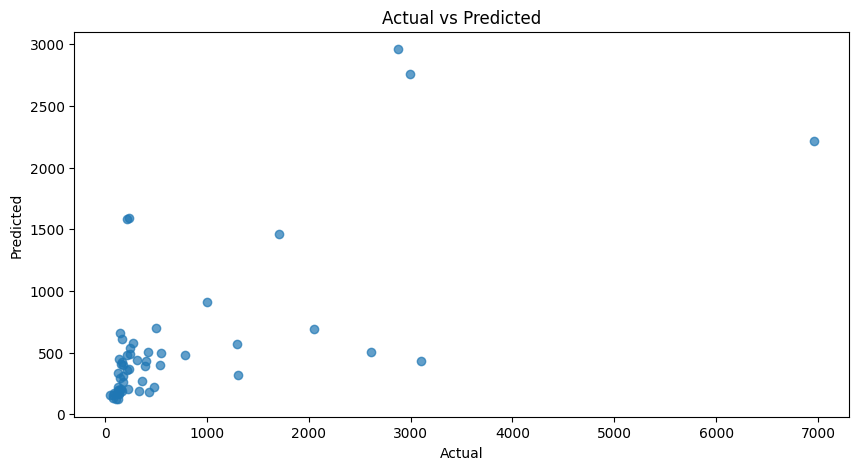

<Figure size 640x480 with 0 Axes>

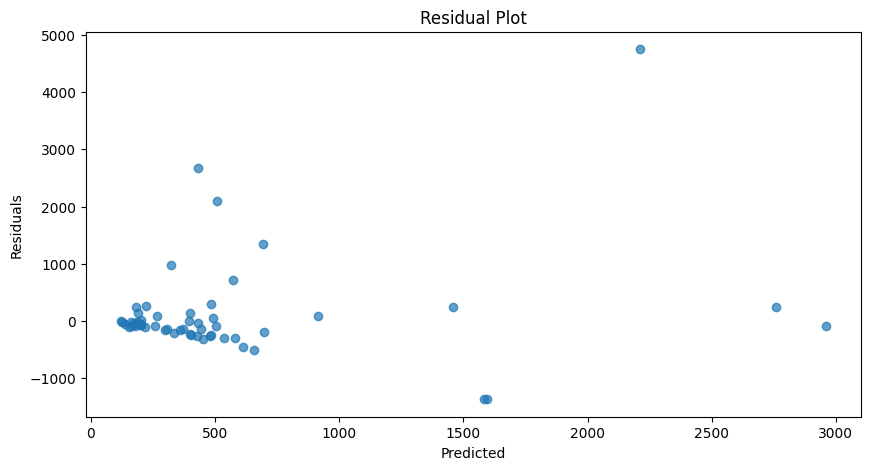

<Figure size 640x480 with 0 Axes>

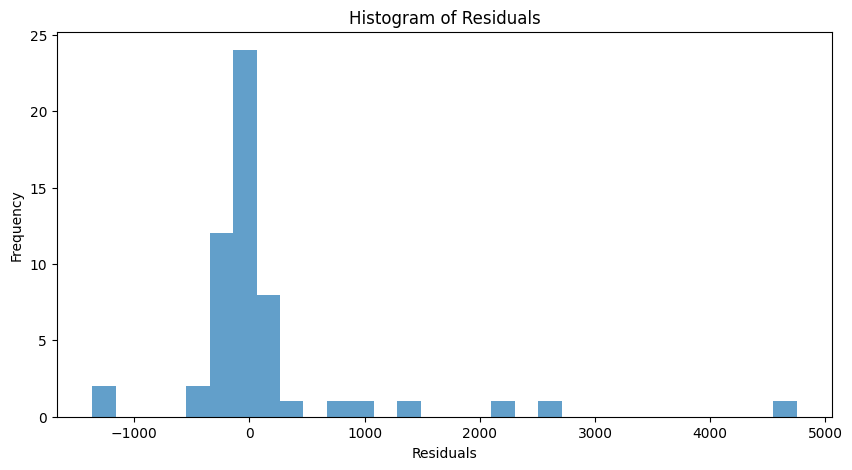

<Figure size 640x480 with 0 Axes>

In [17]:
# Calculate residuals
residuals = y_test - y_pred

# 1. Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

plt.savefig(os.path.join(figs_folder, 'regression_pred_dif.png'))

# 2. Residual plot
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

plt.savefig(os.path.join(figs_folder, 'regression_residual_dif.png'))

# 3. Histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

plt.savefig(os.path.join(figs_folder, 'regression_residual_hist.png'))

# References

https://medium.com/@lomashbhuva/understanding-feature-importance-in-machine-learning-d86ec50e0055

https://medium.com/@mehmetalitor/top-15-machine-learning-regression-algorithms-2cf128c8935e
